# ***INSTALL DEPENDENCIES*** #

In [4]:
import os
import os.path as op
import tarfile
from zipfile import ZipFile
from urllib.request import urlretrieve


def create_folder(folder):
    if not op.exists(folder):
        os.mkdir(folder)
        print(f"Creating:\t\t {folder}")
    else:
        print(f"Already exist:\t\t {folder}")

def download_file(url, filename):
    if not op.exists(filename):
        print(f"Downloading:\t\t {url} --> {filename}")
        urlretrieve(url, filename)
    else:
        print(f"Already downloaded:\t {url} --> {filename}")

def extract_file(main, filename, foldername):
    if not op.exists(foldername):
        print(f'Extracting:\t\t {filename} --> {foldername}')
        file_extension = os.path.splitext(filename)[1].lower()
        if file_extension == '.zip':
            with ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall(main)
        elif file_extension in ('.tar', '.gz', '.bz2', '.xz'):
            with tarfile.open(filename, 'r:*') as tar_ref:
                tar_ref.extractall(path=main)
        else:
            print(f"Unsupported file type: {file_extension}")
    else:
        print(f'Already extracted:\t {filename} --> {foldername}')


DOWNLOADS = "Downloads"
ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILE = DOWNLOADS + "/ml-100k.zip"
ML_100K_FOLDER = DOWNLOADS + "/ml-100k"

create_folder(DOWNLOADS)
download_file(ML_100K_URL, ML_100K_FILE)
extract_file(DOWNLOADS, ML_100K_FILE, ML_100K_FOLDER)

Creating:		 Downloads
Downloading:		 http://files.grouplens.org/datasets/movielens/ml-100k.zip --> Downloads/ml-100k.zip
Extracting:		 Downloads/ml-100k.zip --> Downloads/ml-100k


# **PART I: Neural Recommender System** #

# Step 1: Loading and Exploring the Dataset

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# Load ratings
raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t', names=["user_id", "item_id", "rating", "timestamp"])

# Load item metadata
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|', names=m_cols, usecols=range(5), encoding='latin-1')

# Display first few rows
print("Ratings DataFrame:")
print(raw_ratings.head())
print("\nItems DataFrame:")
print(items.head())

Ratings DataFrame:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

Items DataFrame:
   item_id              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...  
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...  
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...  
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...  
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)  


# Step 2: Preprocessing the Data

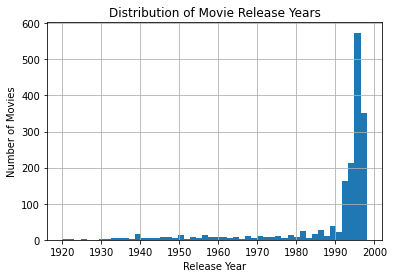

In [6]:
from sklearn.model_selection import train_test_split


# Extract release year from release_date
def extract_year(release_date):
    if isinstance(release_date, str):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    return 1920  # Default for missing values

items['release_year'] = items['release_date'].map(extract_year)

# Visualize release year distribution
items.hist('release_year', bins=50)
plt.title("Distribution of Movie Release Years")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.show()

## Step 2.1: See the Content of the DataFrame

In [7]:
# Merge ratings with items
all_ratings = pd.merge(items, raw_ratings, on='item_id')
print("Merged DataFrame (first 5 rows):\n", all_ratings.head())

# Get max user and item IDs
max_user_id = all_ratings['user_id'].max()
max_item_id = all_ratings['item_id'].max()
print(f"\n\n\nMax user ID:\n {max_user_id}, Max item ID: {max_item_id}")

# Rating statistics
print("\n\n\nRating Statistics:\n", all_ratings['rating'].describe())

# Calculate movie popularity
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items, on='item_id')
print("\n\n\nTop 10 Most Popular Movies:\n", items.nlargest(10, 'popularity')[['title', 'popularity']].to_string(index=False))


# Enrich ratings with popularity
all_ratings = pd.merge(popularity, all_ratings, on='item_id')

# Split into train and test sets
ratings_train, ratings_test = train_test_split(all_ratings, test_size=0.2, random_state=0)

# Extract features for training and testing
user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

Merged DataFrame (first 5 rows):
    item_id             title release_date  video_release_date  \
0        1  Toy Story (1995)  01-Jan-1995                 NaN   
1        1  Toy Story (1995)  01-Jan-1995                 NaN   
2        1  Toy Story (1995)  01-Jan-1995                 NaN   
3        1  Toy Story (1995)  01-Jan-1995                 NaN   
4        1  Toy Story (1995)  01-Jan-1995                 NaN   

                                            imdb_url  release_year  user_id  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      308   
1  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      287   
2  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      148   
3  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      280   
4  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995       66   

   rating  timestamp  
0       4  887736532  
1       5  875334088  
2       4  877019411  
3       

# Step 3: Building a Simple Embedding Model

In [8]:
from keras.layers import Input, Embedding, Flatten, Dot
from keras.models import Model


# Define inputs
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

# Embedding layers
embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1, input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1, input_length=1, name='item_embedding')(item_id_input)

# Flatten embeddings
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

# Dot product
y = Dot(axes=1)([user_vecs, item_vecs])

# Build and compile model
model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

# Initial predictions
initial_train_preds = model.predict([user_id_train, item_id_train])
print("Shape of initial predictions:", initial_train_preds.shape)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Shape of initial predictions: (80000, 1)


# Step 4: Evaluating the Untrained Model

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


# Compute errors
squared_differences = np.square(initial_train_preds[:, 0] - rating_train.values)
absolute_differences = np.abs(initial_train_preds[:, 0] - rating_train.values)

print("Random init MSE: %.3f" % np.mean(squared_differences))
print("Random init MAE: %.3f" % np.mean(absolute_differences))

# Verify with scikit-learn
print("Random init MSE (sklearn): %.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE (sklearn): %.3f" % mean_absolute_error(initial_train_preds, rating_train))

Random init MSE: 13.720
Random init MAE: 3.529
Random init MSE (sklearn): 13.720
Random init MAE (sklearn): 3.529


# Step 5: Training the Model

Train on 72000 samples, validate on 8000 samples
Epoch 1/6
72000/72000 [==============================] - 1s 11us/step - loss: 2.8982 - val_loss: 1.3095
Epoch 2/6
72000/72000 [==============================] - 1s 11us/step - loss: 0.9610 - val_loss: 0.8351
Epoch 3/6
72000/72000 [==============================] - 1s 11us/step - loss: 0.7818 - val_loss: 0.7841
Epoch 4/6
72000/72000 [==============================] - 1s 11us/step - loss: 0.7505 - val_loss: 0.7706
Epoch 5/6
72000/72000 [==============================] - 1s 11us/step - loss: 0.7382 - val_loss: 0.7649
Epoch 6/6
72000/72000 [==============================] - 1s 12us/step - loss: 0.7308 - val_loss: 0.7577


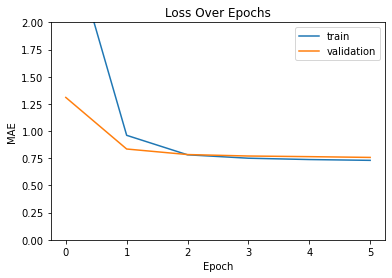

Final test MSE: 0.958
Final test MAE: 0.753
Final train MSE: 0.875
Final train MAE: 0.713


In [10]:
# Train the model
history = model.fit([user_id_train, item_id_train], rating_train, batch_size=64, epochs=6, validation_split=0.1, shuffle=True)

# Plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

# Evaluate on test set
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %.3f" % mean_absolute_error(test_preds, rating_test))

# Evaluate on training set
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %.3f" % mean_absolute_error(train_preds, rating_train))

# Step 6: Building a Deep Recommender Model

Train on 64000 samples, validate on 16000 samples
Epoch 1/5
64000/64000 [==============================] - 1s 18us/step - loss: 1.0171 - val_loss: 0.7610
Epoch 2/5
64000/64000 [==============================] - 1s 16us/step - loss: 0.7526 - val_loss: 0.7485
Epoch 3/5
64000/64000 [==============================] - 1s 15us/step - loss: 0.7386 - val_loss: 0.7432
Epoch 4/5
64000/64000 [==============================] - 1s 15us/step - loss: 0.7294 - val_loss: 0.7363
Epoch 5/5
64000/64000 [==============================] - 1s 15us/step - loss: 0.7222 - val_loss: 0.7346


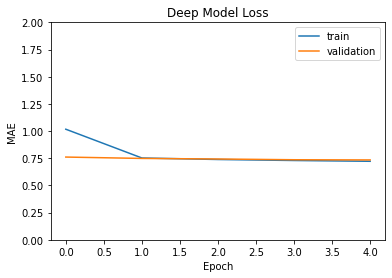

Deep model test MSE: 0.906
Deep model test MAE: 0.732
Deep model train MSE: 0.855
Deep model train MAE: 0.704


In [11]:
from keras.layers import Concatenate, Dense, Dropout


# Define inputs
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

# Embeddings
embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1, input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1, input_length=1, name='item_embedding')(item_id_input)

# Flatten
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

# Concatenate and add dense layers
input_vecs = Concatenate()([user_vecs, item_vecs])
input_vecs = Dropout(0.3)(input_vecs)  # Prevent overfitting
x = Dense(64, activation='relu')(input_vecs)
y = Dense(1, activation='linear')(x)

# Build and compile
model_deep = Model(inputs=[user_id_input, item_id_input], outputs=y)
model_deep.compile(optimizer='adam', loss='mae')

# Train
history_deep = model_deep.fit([user_id_train, item_id_train], rating_train, batch_size=64, epochs=5, validation_split=0.2, shuffle=True)

# Plot loss
plt.plot(history_deep.history['loss'], label='train')
plt.plot(history_deep.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Deep Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

# Evaluate
test_preds_deep = model_deep.predict([user_id_test, item_id_test])
print("Deep model test MSE: %.3f" % mean_squared_error(test_preds_deep, rating_test))
print("Deep model test MAE: %.3f" % mean_absolute_error(test_preds_deep, rating_test))

train_preds_deep = model_deep.predict([user_id_train, item_id_train])
print("Deep model train MSE: %0.3f" % mean_squared_error(train_preds_deep, rating_train))
print("Deep model train MAE: %0.3f" % mean_absolute_error(train_preds_deep, rating_train))

# Step 7: Retrieving Embeddings

In [13]:
weights = model.get_weights()
print("\n\nWeights:\n", [w.shape for w in weights])
model.summary()

weights_deep = model_deep.get_weights()
print("\n\nWeights Deep:\n", [w.shape for w in weights_deep])
model_deep.summary()



Weights:
 [(944, 30), (1683, 30)]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 30)        28320       user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 30)        50490       item[0][0]                       
________________________________________________________

## Step 7.1: Printing Embeddings

In [14]:
# weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]
print("Model Metadata:")
print("\nFirst item name from metadata:", items["title"][1])
print("\nEmbedding vector for the first item:", item_embeddings[1])
print("\nShape:", item_embeddings[1].shape)


# weights_deep = model_deep.get_weights()
user_embeddings = weights_deep[0]
item_embeddings = weights_deep[1]
print("\n\n\nDeep Metadata:")
print("\nFirst item name from metadata:", items["title"][1])
print("\nEmbedding vector for the first item:", item_embeddings[1])
print("\nShape:", item_embeddings[1].shape)

Model Metadata:

First item name from metadata: GoldenEye (1995)

Embedding vector for the first item: [ 0.4002624   0.4678607   0.48067236 -0.47568205  0.45975766 -0.2511023
 -0.4143912   0.29659647  0.36518803  0.4071984   0.4454395   0.49634808
 -0.36858445 -0.42241     0.25932413 -0.28245378  0.48368946 -0.12053722
 -0.26469693 -0.44692254  0.354315   -0.09302636  0.35390413 -0.30929944
 -0.40046328  0.40744135  0.4487741  -0.28225008  0.35443702  0.2181287 ]

Shape: (30,)



Deep Metadata:

First item name from metadata: GoldenEye (1995)

Embedding vector for the first item: [-3.2769125e-02  3.9596561e-02  6.7122571e-02  6.4140789e-02
 -1.3636629e-01 -1.8754616e-02  2.8663924e-02 -5.5105098e-02
 -2.9977569e-02  5.7584416e-02  1.7244471e-02  6.0836602e-02
  7.7477209e-02 -8.1040516e-02  4.5561469e-03  7.6673500e-02
  2.7227085e-05  7.1852908e-02  4.8450164e-02  2.3143392e-02
 -7.4352987e-02  9.0411231e-02  3.9956108e-02 -8.5802160e-02
 -2.6693422e-02 -8.3633371e-02  9.5849805e-02 -

## Step 7.2: cosine(), cosine_similarities(), euclidean_distances(), most_similar()

In [15]:
def cosine(x, y):
    x = x / np.linalg.norm(x)
    y = y / np.linalg.norm(y)
    return np.dot(x, y)

def cosine_similarities(x):
    # TODO
    pass

def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

def most_similar(idx, top_n=10, mode='euclidean'):
    if mode == 'euclidean':
        dists = euclidean_distances(item_embeddings[idx])
    else:
        dists = -np.array([cosine(item_embeddings[idx], emb) for emb in item_embeddings])
    top_indices = np.argsort(dists)[1:top_n+1]  # Exclude self
    return [(items.iloc[i]['title'], dists[i]) for i in top_indices]


# Retrieve movie titles for the given IDs
movie_181 = items.loc[items['item_id'] == 181, 'title'].values[0]

# most similar
print(f"\nMovies similar to {movie_181}:\n", most_similar(181))

# sanity checks
print(f"\ncosine of item 1 and item 1:\n {cosine(item_embeddings[1], item_embeddings[1]):0.3f}")

# euclidean distances
euc_dists = euclidean_distances(item_embeddings[1])
print("\neuclidean_distances shape:\n", euc_dists.shape)
print("\neuclidean_distances dictionary:\n", euc_dists[1:5])

# Display most similar movies with proper formatting
print(f"\nMovies similar to {movie_181}:")
for title, dist in most_similar(181, mode="euclidean"):
    print(f"{title:<40}: {dist:.3f}")


Movies similar to Return of the Jedi (1983):
 [('Hana-bi (1997)', 0.23180829), ('Adventures of Robin Hood, The (1938)', 0.23216604), ('Van, The (1996)', 0.23239185), ('Dances with Wolves (1990)', 0.23353331), ('Silence of the Palace, The (Saimt el Qusur) (1994)', 0.23939225), ('Paris, Texas (1984)', 0.24038242), ('Searching for Bobby Fischer (1993)', 0.24091606), ('Witness (1985)', 0.24214037), ('Babe (1995)', 0.24557908), ('Thousand Acres, A (1997)', 0.24697414)]

cosine of item 1 and item 1:
 1.000

euclidean_distances shape:
 (1683,)

euclidean_distances dictionary:
 [0.         0.41354927 0.4889696  0.29013848]

Movies similar to Return of the Jedi (1983):
Hana-bi (1997)                          : 0.232
Adventures of Robin Hood, The (1938)    : 0.232
Van, The (1996)                         : 0.232
Dances with Wolves (1990)               : 0.234
Silence of the Palace, The (Saimt el Qusur) (1994): 0.239
Paris, Texas (1984)                     : 0.240
Searching for Bobby Fischer (199

## Step 7.3: Visualizing Embeddings

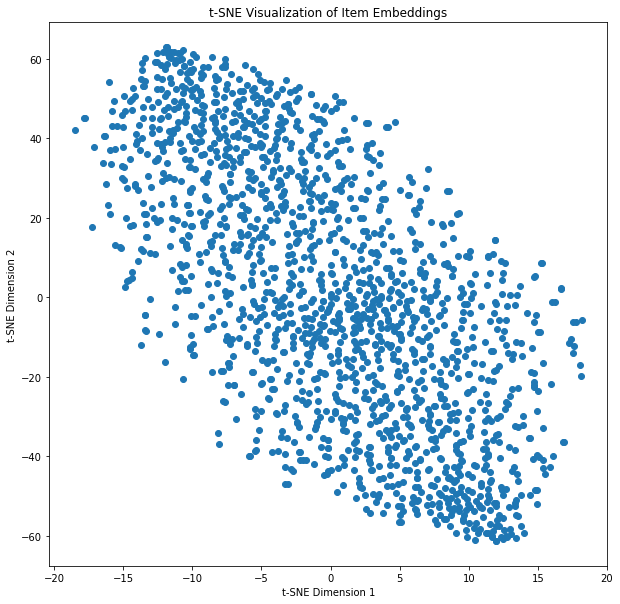

In [16]:
from sklearn.manifold import TSNE


item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1])
plt.title("t-SNE Visualization of Item Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Step 8: Making Recommendations

In [17]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id + 1)
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = [i for i in item_ids if i not in seen_movies]

    print(f"\nUser {user_id} has seen {len(seen_movies)} movies, including:")
    for title in all_ratings[seen_mask].nlargest(5, 'popularity')['title']:
        print(f"   {title}")
    print(f"\nComputing ratings for {len(item_ids)} other movies:")

    user_ids = np.full(len(item_ids), user_id)
    rating_preds = model_deep.predict([user_ids, np.array(item_ids)])

    item_preds = list(zip(item_ids, rating_preds[:, 0]))
    item_preds.sort(key=lambda x: x[1], reverse=True)
    rec_items = item_preds[:top_n]
    return [(items.iloc[i-1]['title'], pred) for i, pred in rec_items]  # Adjust for 0-based indexing

# Recommend for user 5
print("\nRecommendations for user 5:")
for title, pred_rating in recommend(5):
    print(f"    {pred_rating:.1f}: {title}")


Recommendations for user 5:

User 5 has seen 175 movies, including:
   Star Wars (1977)
   Fargo (1996)
   Return of the Jedi (1983)
   Toy Story (1995)
   Independence Day (ID4) (1996)

Computing ratings for 1507 other movies:
    4.3: Schindler's List (1993)
    4.2: Casablanca (1942)
    4.2: Usual Suspects, The (1995)
    4.1: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
    4.1: Prefontaine (1997)
    4.1: Shawshank Redemption, The (1994)
    4.1: Rear Window (1954)
    4.1: Godfather, The (1972)
    4.1: To Live (Huozhe) (1994)
    4.1: Titanic (1997)


# **PART II: Embeddings with Keras** #

# Step 1: Import Libraries and Create Embedding Matrix

In [18]:
import numpy as np


embedding_size = 4
vocab_size = 10

# Create the embedding matrix
embedding_matrix = np.arange(embedding_size * vocab_size, dtype='float32')
embedding_matrix = embedding_matrix.reshape(vocab_size, embedding_size)
print("\nEmbedding Matrix:\n", embedding_matrix)

# Example index to fetch an embedding
i = 3
print(f"\nEmbedding vector for index {i}:\n", embedding_matrix[i])


Embedding Matrix:
 [[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]
 [16. 17. 18. 19.]
 [20. 21. 22. 23.]
 [24. 25. 26. 27.]
 [28. 29. 30. 31.]
 [32. 33. 34. 35.]
 [36. 37. 38. 39.]]

Embedding vector for index 3:
 [12. 13. 14. 15.]


# Step 2: Define One-Hot Encoding and Calculate the Embedding Vector

In [19]:
def onehot_encode(dim, label):
    return np.eye(dim)[label]

# One-hot encode for the given index
onehot_i = onehot_encode(vocab_size, i)
print(f"\nOne-hot encoded vector for index {i}:\n", onehot_i)

# Compute the embedding vector by multiplying one-hot vector with the embedding matrix
embedding_vector = np.dot(onehot_i, embedding_matrix)
print(f"\nEmbedding vector for index {i}:\n", embedding_vector)


One-hot encoded vector for index 3:
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

Embedding vector for index 3:
 [12. 13. 14. 15.]


# Step 3: Create the Keras Embedding Layer

In [21]:
from keras.layers import Embedding
from keras.layers import Input
from keras.models import Model


# Define the embedding layer
embedding_layer = Embedding(output_dim=embedding_size, input_dim=vocab_size, weights=[embedding_matrix], input_length=1, name='my_embedding')

# Set up the Keras model using the embedding layer
x = Input(shape=[1], name='input')
embedding = embedding_layer(x)
model = Model(inputs=x, outputs=embedding)

# Print the output shape of the model
print(f"\nModel output shape:\n {model.output_shape}")

# Print model weights (embedding weights)
print(f"\nModel weights:\n", model.get_weights())

# Print model summary to show trainable parameters
model.summary()


Model output shape:
 (None, 1, 4)

Model weights:
 [array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.],
       [16., 17., 18., 19.],
       [20., 21., 22., 23.],
       [24., 25., 26., 27.],
       [28., 29., 30., 31.],
       [32., 33., 34., 35.],
       [36., 37., 38., 39.]], dtype=float32)]
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
my_embedding (Embedding)     (None, 1, 4)              40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


# Step 4: Make Predictions with the Keras Embedding Model

In [22]:
labels_to_encode = np.array([[3]])
print(f"\nPrediction for label 3:\n", model.predict(labels_to_encode))

labels_to_encode = np.array([[3], [3], [0], [9]])
print(f"\nPredictions for labels [3, 3, 0, 9]:\n", model.predict(labels_to_encode))


Prediction for label 3:
 [[[12. 13. 14. 15.]]]

Predictions for labels [3, 3, 0, 9]:
 [[[12. 13. 14. 15.]]

 [[12. 13. 14. 15.]]

 [[ 0.  1.  2.  3.]]

 [[36. 37. 38. 39.]]]


# Step 5: Flatten the Output of the Embedding Layer

In [23]:
from keras.layers import Flatten


# Modify the model to flatten the output (removing the sequence dimension)
y = Flatten()(embedding_layer(x))
model2 = Model(inputs=x, outputs=y)

# Print the output shape of the new model
print(f"\nNew model output shape after flattening:\n {model2.output_shape}")

# Test the flattened model with a sample input
print(f"\nPrediction for label 3 after flattening:\n", model2.predict(np.array([3])))


New model output shape after flattening:
 (None, 4)

Prediction for label 3 after flattening:
 [[12. 13. 14. 15.]]
